In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import pickle
import cartopy.crs as ccrs
import geopandas as gpd
from palettable.colorbrewer.diverging import RdBu_10
import gdal

import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg
from osgeo import osr

# Get ATL15, 2019 dH

In [2]:
src_path = "ATL15_AA_0311_01km_001_01.nc"
ds = xr.open_dataset(src_path, group='delta_h')

M2_RF = xr.open_dataset("RF_Snow_Red_prelim.nc")['IS2_opt']
M2_RF = M2_RF / M2_RF

In [3]:
indf = 9
ind0 = 5
dh = ds['delta_h'][indf,:,:] - ds['delta_h'][ind0,:,:]
grounded_mask = np.load("grounded-mask/grounded_mask.npy")
grounded_mask = xr.DataArray(data=np.flipud(grounded_mask), dims=["y", "x"], coords=[ds['y'],ds['x']])
dh = dh * grounded_mask * M2_RF
print(ds['time'][ind0].values)
print(ds['time'][indf].values)

2020-01-01T12:00:00.000000000
2020-12-31T18:00:00.000000000


# Get GIA on ATL15 grid

<xarray.DataArray ()>
array(0.00138462)


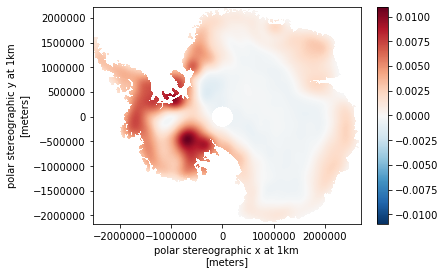

In [4]:
# Open file
tif = gdal.Open("GIA_AnIS_ICE6G_D_High_Res_L120_5km.tif")

# Get data 
band = tif.GetRasterBand(1)
GIA = np.flipud(band.ReadAsArray())

# Get x and y
ulx, xres, xskew, uly, yskew, yres  = tif.GetGeoTransform()
lrx = ulx + (tif.RasterXSize * xres)
lry = uly + (tif.RasterYSize * yres)
X = np.linspace(ulx, lrx, tif.RasterXSize)
Y = np.linspace(lry, uly, tif.RasterYSize)

# Get into xarray on ATL15 grid
GIA = xr.DataArray(data=GIA, dims=["y", "x"], coords=[Y, X])
GIA = GIA.interp(x=dh['x'], y=dh['y'])

# Mask
GIA = GIA * grounded_mask * M2_RF
print(GIA.mean())
GIA.plot()

# Save lat/lon array

In [5]:
# Get source x and y
src_x = dh['x']
src_y = dh['y']

# Create meshgrid then squash to a vector
src_x, src_y = np.meshgrid(src_x, src_y)
src_x = src_x.flatten()
src_y = src_y.flatten()

# Convert x and y vector to lat/lon vector
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(3031) # South Polar Stereo
tgt.ImportFromEPSG(4326) # WGS 84

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
tgt_lon = np.zeros(len(src_x)); tgt_lon[:] = np.nan
tgt_lat = np.zeros(len(src_x)); tgt_lat[:] = np.nan

# Perform transformation
for j in range(0, len(tgt_lon)):
    coords = transform.TransformPoint(float(src_x[j]), float(src_y[j]))
    tgt_lat[j], tgt_lon[j] = coords[0:2]
    
# Compile into array and save
lat_lon = np.transpose(np.stack([tgt_lat, tgt_lon]))
print(lat_lon.shape)

# Save array
np.save("IC2_lat_lon.npy", lat_lon)

# Save shape
shape = dh.shape
with open('ATL15_shape.pkl', 'wb') as f:
    pickle.dump(shape, f)

(22977621, 2)


# Get dFAC corrected dH

In [6]:
inference = np.load("2020_Inference_Y.npy")
inference = np.reshape(inference, dh.shape)
inference = xr.DataArray(data=inference, dims=["y", "x"], coords=[dh['y'], dh['x']])
inference = inference * grounded_mask
dh_corr = dh - inference - GIA

# Make figures

In [7]:
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
df = df.to_crs(epsg='3031')
n_poly = len(df['geometry'])

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


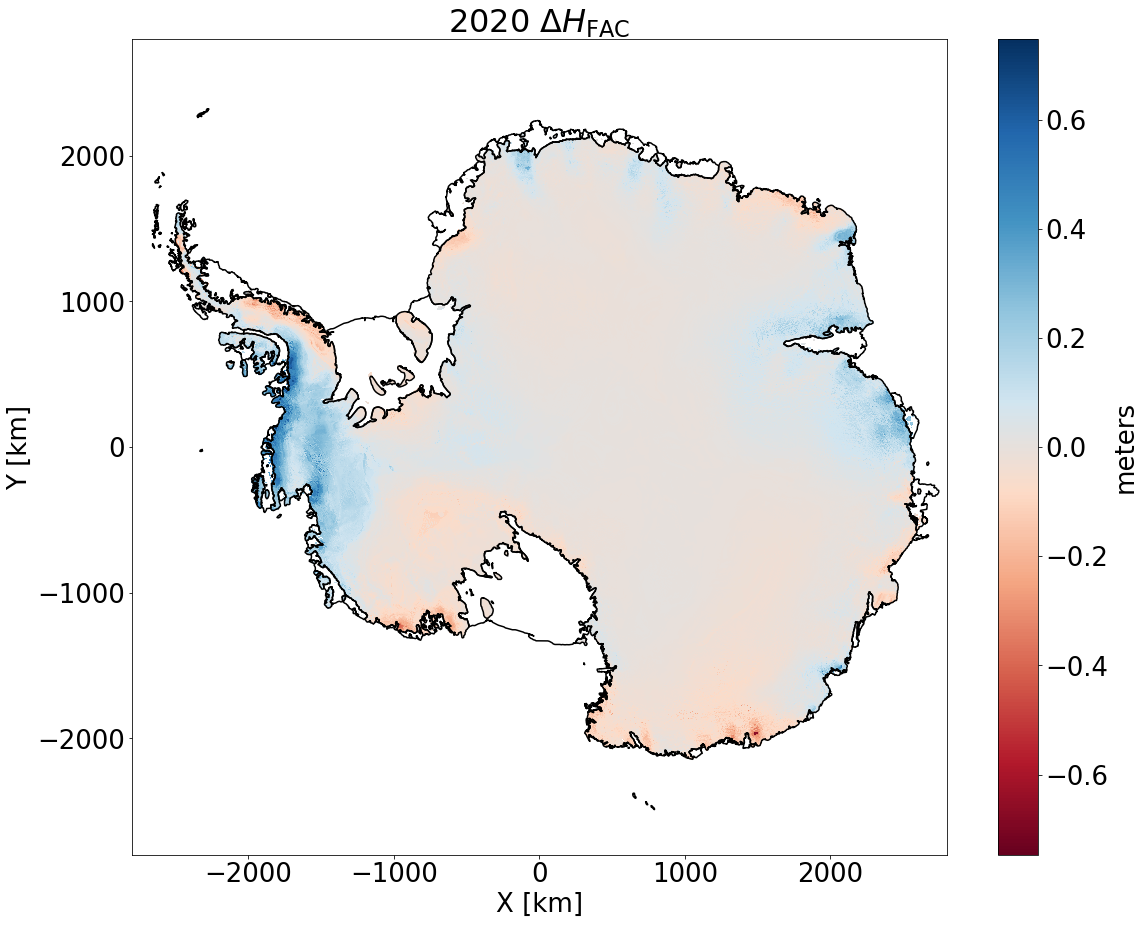

In [8]:
# dFAC
lim = np.max(np.abs(inference))
axis_lim = 2800
plt.figure(figsize=(18.25, 15))

for j in range(0, n_poly):
    x_poly, y_poly = df['geometry'][j].exterior.coords.xy
    x_poly = np.array(x_poly)
    y_poly = np.array(y_poly)
    x_poly = np.append(x_poly/1000, x_poly[0]/1000)
    y_poly = np.append(y_poly/1000, y_poly[0]/1000)
    plt.plot(x_poly, y_poly, 'k-')

plt.pcolormesh(dh_corr['x']/1000, dh_corr['y']/1000, \
           inference, cmap=RdBu_10.mpl_colormap, \
          vmin=-lim, vmax=lim, rasterized=True)
cb = plt.colorbar()
cb.set_label("meters", fontsize=26)
cb.ax.tick_params(labelsize=26) 
plt.xlabel("X [km]", fontsize=26)
plt.ylabel("Y [km]", fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.title("2020 $\Delta H_{\mathrm{FAC}}$", fontsize=32)
plt.xlim([-axis_lim, axis_lim])
plt.ylim([-axis_lim, axis_lim])
plt.savefig("figures/dFAC_map_AIS.pdf", dpi=100)

In [9]:
# # dH
# image_scale = 1
# lim = 3
# plt.figure(figsize=(20, 15))
# plt.pcolormesh(dh_corr['x'][::image_scale]/1000, dh_corr['y'][::image_scale]/1000, \
#            dh[::image_scale, ::image_scale], cmap=plt.cm.RdBu, \
#           vmin=-lim, vmax=lim, rasterized=True)
# cb = plt.colorbar()
# cb.set_label("meters", fontsize=26)
# cb.ax.tick_params(labelsize=26) 
# plt.xlabel("X [km]", fontsize=26)
# plt.ylabel("Y [km]", fontsize=26)
# plt.xticks(fontsize=26)
# plt.yticks(fontsize=26)
# plt.title("2019 Surface Height Change", fontsize=32)
# plt.savefig("figures/dH_map_AIS.pdf", dpi=100)
# print(dh.var())

<xarray.DataArray ()>
array(0.05167055)


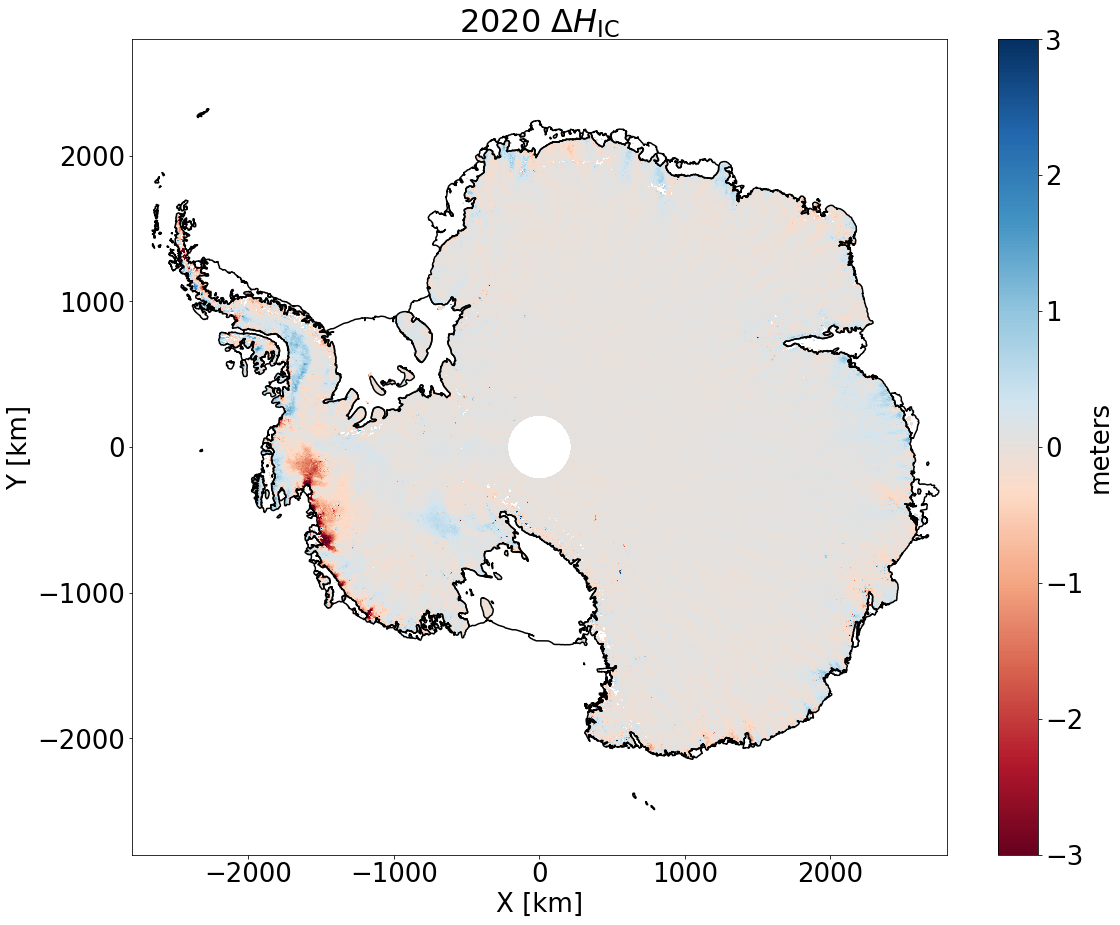

In [10]:
# dH_corr
image_scale = 1
axis_lim = 2800
lim = 3
plt.figure(figsize=(18.25, 15))

for j in range(0, n_poly):
    x_poly, y_poly = df['geometry'][j].exterior.coords.xy
    x_poly = np.array(x_poly)
    y_poly = np.array(y_poly)
    x_poly = np.append(x_poly/1000, x_poly[0]/1000)
    y_poly = np.append(y_poly/1000, y_poly[0]/1000)
    plt.plot(x_poly, y_poly, 'k-')

plt.pcolormesh(dh_corr['x'][::image_scale]/1000, dh_corr['y'][::image_scale]/1000, \
           dh_corr[::image_scale, ::image_scale], cmap=RdBu_10.mpl_colormap, \
          vmin=-lim, vmax=lim, rasterized=True)
cb = plt.colorbar()
cb.set_label("meters", fontsize=26)
cb.ax.tick_params(labelsize=26) 
plt.xlabel("X [km]", fontsize=26)
plt.ylabel("Y [km]", fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.title("2020 $\Delta H_{\mathrm{IC}}$", fontsize=32)
plt.xlim([-axis_lim, axis_lim])
plt.ylim([-axis_lim, axis_lim])
plt.savefig("figures/dH_corr_map_AIS.pdf", dpi=100)
print(dh_corr.var())

# Mass balance calculation

In [11]:
# Regional mass balance
MB = 917 * dh_corr * ds['cell_area']
MB = MB.sum() / 1e12
print()
print("****** No GIA correction has been applied ******")
print("Mass balance = " + str(MB.values) + " Gt")
print("****** No GIA correction has been applied ******")


****** No GIA correction has been applied ******
Mass balance = 184.3791255439783 Gt
****** No GIA correction has been applied ******


# Amundsen Sea

In [ ]:
# Coastal West Antarctica
x_min = -2000e3
x_max = -1200e3
y_min = -1200e3
y_max = 250e3

x1_ind = (inference['x'] > x_min)
x2_ind = (inference['x'] < x_max)
x_ind = np.logical_and(x1_ind, x2_ind)

y1_ind = (inference['y'] > y_min)
y2_ind = (inference['y'] < y_max)
y_ind = np.logical_and(y1_ind, y2_ind)

# Get coastlines
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(7, 7))

# Plot sites
x = [dh_corr['x'][x_ind].min(), dh_corr['x'][x_ind].min(), dh_corr['x'][x_ind].max(), dh_corr['x'][x_ind].max(), dh_corr['x'][x_ind].min()]
y = [dh_corr['y'][y_ind].min(), dh_corr['y'][y_ind].max(), dh_corr['y'][y_ind].max(), dh_corr['y'][y_ind].min(), dh_corr['y'][y_ind].min()]

plt.plot(x, y, 'r-', linewidth=3)


# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

In [ ]:
# dFAC
lim = np.abs(inference).max()
plt.figure(figsize=(12, 15))

for j in range(0, n_poly):
    x_poly, y_poly = df['geometry'][j].exterior.coords.xy
    x_poly = np.array(x_poly)
    y_poly = np.array(y_poly)
    x_poly = np.append(x_poly/1000, x_poly[0]/1000)
    y_poly = np.append(y_poly/1000, y_poly[0]/1000)
    plt.plot(x_poly, y_poly, 'k-')
    
plt.pcolormesh(dh_corr['x'][x_ind]/1000, dh_corr['y'][y_ind]/1000, \
           inference[y_ind, x_ind], cmap=RdBu_10.mpl_colormap, \
          vmin=-lim, vmax=lim, rasterized=True)
cb = plt.colorbar()
cb.set_label("meters", fontsize=20)
cb.ax.tick_params(labelsize=20) 
plt.xlabel("X [km]", fontsize=20)
plt.ylabel("Y [km]", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("2019 $\Delta H_{\mathrm{FAC}}$", fontsize=32)
plt.xlim([inference[y_ind, x_ind]['x'].min()/1000, inference[y_ind, x_ind]['x'].max()/1000])
plt.ylim([inference[y_ind, x_ind]['y'].min()/1000, inference[y_ind, x_ind]['y'].max()/1000])
plt.savefig("figures/dFAC_map_AIS.pdf", dpi=100)

In [ ]:
# dH_Corr
lim = 3
plt.figure(figsize=(12, 15))

for j in range(0, n_poly):
    x_poly, y_poly = df['geometry'][j].exterior.coords.xy
    x_poly = np.array(x_poly)
    y_poly = np.array(y_poly)
    x_poly = np.append(x_poly/1000, x_poly[0]/1000)
    y_poly = np.append(y_poly/1000, y_poly[0]/1000)
    plt.plot(x_poly, y_poly, 'k-')

plt.pcolormesh(dh_corr['x'][x_ind]/1000, dh_corr['y'][y_ind]/1000, \
           dh_corr[y_ind, x_ind], cmap=RdBu_10.mpl_colormap, \
          vmin=-lim, vmax=lim, rasterized=True)
cb = plt.colorbar()
cb.set_label("meters", fontsize=20)
cb.ax.tick_params(labelsize=20) 
plt.xlabel("X [km]", fontsize=20)
plt.ylabel("Y [km]", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("2019 $\Delta H_{\mathrm{IC}}$", fontsize=32)
plt.xlim([inference[y_ind, x_ind]['x'].min()/1000, inference[y_ind, x_ind]['x'].max()/1000])
plt.ylim([inference[y_ind, x_ind]['y'].min()/1000, inference[y_ind, x_ind]['y'].max()/1000])
plt.savefig("figures/dH_corr_map_AIS.pdf", dpi=100)

# Dronning Maud Land

In [ ]:
# DML
x_min = -750e3
x_max = 2350e3
y_min = 1000e3
y_max = 2250e3
ratio = (x_max - x_min) / (y_max - y_min)
print(ratio)

x1_ind = (inference['x'] > x_min)
x2_ind = (inference['x'] < x_max)
x_ind = np.logical_and(x1_ind, x2_ind)

y1_ind = (inference['y'] > y_min)
y2_ind = (inference['y'] < y_max)
y_ind = np.logical_and(y1_ind, y2_ind)

# Get coastlines
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(7, 7))

# Plot sites
x2 = [dh_corr['x'][x_ind].min(), dh_corr['x'][x_ind].min(), dh_corr['x'][x_ind].max(), dh_corr['x'][x_ind].max(), dh_corr['x'][x_ind].min()]
y2 = [dh_corr['y'][y_ind].min(), dh_corr['y'][y_ind].max(), dh_corr['y'][y_ind].max(), dh_corr['y'][y_ind].min(), dh_corr['y'][y_ind].min()]

plt.plot(x, y, 'b-', linewidth=3)


# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

In [ ]:
# dFAC
lim = np.abs(inference).max()
plt.figure(figsize=(23, 7))

for j in range(0, n_poly):
    x_poly, y_poly = df['geometry'][j].exterior.coords.xy
    x_poly = np.array(x_poly)
    y_poly = np.array(y_poly)
    x_poly = np.append(x_poly/1000, x_poly[0]/1000)
    y_poly = np.append(y_poly/1000, y_poly[0]/1000)
    plt.plot(x_poly, y_poly, 'k-')

plt.pcolormesh(dh_corr['x'][x_ind]/1000, dh_corr['y'][y_ind]/1000, \
           inference[y_ind, x_ind], cmap=RdBu_10.mpl_colormap, \
          vmin=-lim, vmax=lim, rasterized=True)
cb = plt.colorbar()
cb.set_label("meters", fontsize=20)
cb.ax.tick_params(labelsize=20) 
plt.xlabel("X [km]", fontsize=20)
plt.ylabel("Y [km]", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("2019 $\Delta H_{\mathrm{FAC}}$", fontsize=32)
plt.xlim([inference[y_ind, x_ind]['x'].min()/1000, inference[y_ind, x_ind]['x'].max()/1000])
plt.ylim([inference[y_ind, x_ind]['y'].min()/1000, inference[y_ind, x_ind]['y'].max()/1000])
plt.savefig("figures/dFAC_map_AIS.pdf", dpi=100)

In [ ]:
# dH_Corr
lim = 3
plt.figure(figsize=(23, 7))

for j in range(0, n_poly):
    x_poly, y_poly = df['geometry'][j].exterior.coords.xy
    x_poly = np.array(x_poly)
    y_poly = np.array(y_poly)
    x_poly = np.append(x_poly/1000, x_poly[0]/1000)
    y_poly = np.append(y_poly/1000, y_poly[0]/1000)
    plt.plot(x_poly, y_poly, 'k-')
    
plt.pcolormesh(dh_corr['x'][x_ind]/1000, dh_corr['y'][y_ind]/1000, \
           dh_corr[y_ind, x_ind], cmap=RdBu_10.mpl_colormap, \
          vmin=-lim, vmax=lim, rasterized=True)
cb = plt.colorbar()
cb.set_label("meters", fontsize=20)
cb.ax.tick_params(labelsize=20) 
plt.xlabel("X [km]", fontsize=20)
plt.ylabel("Y [km]", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("2019 $\Delta H_{\mathrm{IC}}$", fontsize=32)
plt.xlim([inference[y_ind, x_ind]['x'].min()/1000, inference[y_ind, x_ind]['x'].max()/1000])
plt.ylim([inference[y_ind, x_ind]['y'].min()/1000, inference[y_ind, x_ind]['y'].max()/1000])
plt.savefig("figures/dH_corr_map_AIS.pdf", dpi=100)

# Map

In [ ]:
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot sites
x2 = [dh_corr['x'][x_ind].min(), dh_corr['x'][x_ind].min(), dh_corr['x'][x_ind].max(), dh_corr['x'][x_ind].max(), dh_corr['x'][x_ind].min()]
y2 = [dh_corr['y'][y_ind].min(), dh_corr['y'][y_ind].max(), dh_corr['y'][y_ind].max(), dh_corr['y'][y_ind].min(), dh_corr['y'][y_ind].min()]

plt.plot(x, y, 'r-', linewidth=3)
plt.plot(x2, y2, 'b-', linewidth=3)


# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')
plt.savefig("figures/inset_map.pdf", dpi=100)